In [1]:
 # Load files into Jupyter storage (! calls bash)
!dx download Outputs/data_participant_CC_SLF.csv
!dx download Outputs/data_participant_diagnoses.csv

[===========================================================>] Completed 8,838,274 of 8,838,274 bytes (100%) /opt/notebooks/data_participant_CC_SLF.csvv
[===========================================================>] Completed 18,385,855 of 18,385,855 bytes (100%) /opt/notebooks/data_participant_diagnoses.csvv


In [1]:
# Load packages
install.packages('tidyverse')
install.packages("lmtest")
install.packages('moments')
install.packages('effectsize')

library(tidyverse)
library(lmtest)
library(moments)
library(effectsize)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bayestestR’, ‘insight’, ‘parameters’, ‘performance’, ‘datawizard’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: zoo


Attaching 

In [4]:
# Create dataframes
CC_TIV_df <- read.csv('data_participant_CC_SLF.csv')
diagnoses_df <- read.csv('data_participant_diagnoses.csv')

# Dropping diffusion data for current analysis
CC_TIV_df <- CC_TIV_df %>% 
    select(-p25509_i3,
           -p25059_i2, -p25058_i2, -p25060_i2, -p25107_i2, 
           -p25108_i2, -p25106_i2, -p25097_i2, -p25096_i2, -p25145_i2, 
           -p25144_i2, -p25509_i2, -p25510_i2, -p25536_i2, -p25537_i2)

In [5]:
# Creating list of exclusion codes and identifying ppt ids of healthy ppts

# ICD-10 codes for neurological and psychiatric diseases
icd10_codes <- c(
    # Neurological Diseases (G00-G99)
    "G00", "G01", "G02", "G03", "G04", "G05", "G06", "G07", "G08", "G09",  # Inflammatory CNS diseases
    "G10", "G11", "G12", "G13",  # Systemic atrophies affecting CNS
    "G20", "G21", "G22", "G23", "G24", "G25", "G26",  # Extrapyramidal & movement disorders
    "G30", "G31", "G32",  # Other degenerative CNS diseases
    "G35", "G36", "G37",  # Demyelinating diseases
    "G40", "G41", "G42", "G43", "G44", "G45", "G46", "G47",  # Epilepsy, migraine, sleep disorders
    "G50", "G51", "G52", "G53", "G54", "G55", "G56", "G57", "G58", "G59",  # Nerve & plexus disorders
    "G60", "G61", "G62", "G63", "G64",  # Polyneuropathies & peripheral nervous system disorders
    "G70", "G71", "G72", "G73",  # Neuromuscular junction & muscle diseases
    "G80", "G81", "G82", "G83",  # Cerebral palsy & paralytic syndromes
    "G90", "G91", "G92", "G93", "G94", "G95", "G96", "G97", "G98", "G99",  # Other nervous system disorders

    # Psychiatric Disorders (F00-F99)
    "F00", "F01", "F02", "F03", "F04", "F05", "F06", "F07", "F08", "F09",  # Organic mental disorders (dementia, delirium)
    "F10", "F11", "F12", "F13", "F14", "F15", "F16", "F17", "F18", "F19",  # Substance use disorders
    "F20", "F21", "F22", "F23", "F24", "F25", "F26", "F27", "F28", "F29",  # Schizophrenia & delusional disorders
    "F30", "F31", "F32", "F33", "F34", "F35", "F36", "F37", "F38", "F39",  # Mood (affective) disorders
    "F40", "F41", "F42", "F43", "F44", "F45", "F46", "F47", "F48",  # Anxiety, stress, PTSD, OCD
    "F50", "F51", "F52", "F53", "F54", "F55", "F56", "F57", "F58", "F59",  # Eating & sleep disorders
    "F60", "F61", "F62", "F63", "F64", "F65", "F66", "F67", "F68", "F69",  # Personality disorders
    "F70", "F71", "F72", "F73", "F74", "F75", "F76", "F77", "F78", "F79",  # Intellectual disabilities
    "F80", "F81", "F82", "F83", "F84", "F85", "F86", "F87", "F88", "F89",  # Developmental disorders (ASD, ADHD)
    "F90", "F91", "F92", "F93", "F94", "F95", "F96", "F97", "F98", "F99"   # Childhood-onset behavioral disorders
)

# Filtering diagnoses_df by the list of codes to end up with ids of only healthy participants
healthy_ids_df <- diagnoses_df[!sapply(diagnoses_df$p41270, function(x) any(grepl(paste(icd10_codes, collapse = "|"), x))), ]

In [6]:
# Eliminating participants from the CC_TIV_df who are not listed in the healthy_ids_df; dropping diagnoses column
CC_TIV_df <- inner_join(CC_TIV_df, healthy_ids_df, by = "eid") %>% 
    select(names(CC_TIV_df))

In [7]:
# Summing CC subsection volumes to create total CC volume; assigning columns meaningful names; creating proportional CC column
CC_TIV_df <- CC_TIV_df %>%
    mutate(CC_total = p26535_i2 + p26533_i2 + p26534_i2 + p26532_i2 + p26531_i2) %>%
    rename('age' = p21003_i2, 'sex' = p31, 'hand' = p1707_i0, 'TIV' = p26521_i2, 'CC_anterior' = p26535_i2, 'CC_central' = p26533_i2, 'CC_midanterior' = p26534_i2,
          'CC_midposterior' = p26532_i2, 'CC_posterior' = p26531_i2) %>%
    mutate(CC_prop = CC_total/TIV)

In [8]:
# Ensuring factors are treated as factors in the lm
CC_TIV_df$sex <- as.factor(CC_TIV_df$sex)
CC_TIV_df$hand <- as.factor(CC_TIV_df$hand)

In [9]:
# Changing expression of TIV and CC_total from mm^3 to L
CC_TIV_df <- CC_TIV_df %>%
    mutate(CC_total = CC_total / 1e6) %>%
    mutate(TIV = TIV / 1e6)

In [10]:
# Cleaning handedness data

# Replace empty cells and non-respondents with NAs in order to remove them and subset the dataframe
CC_TIV_df[CC_TIV_df == ''] <- NA
CC_TIV_df[CC_TIV_df == 'Prefer not to answer'] <- NA

# Remove NAs
CC_TIV_df <- na.omit(CC_TIV_df)
# Once the ppts with missing info are omitted we still need to drop the unused levels of the factor
CC_TIV_df <- droplevels(CC_TIV_df)
# Collapsing left-handers and mixed-handers into one factor level bc there are only 2 mixed-handers
CC_TIV_df$hand <- fct_collapse(CC_TIV_df$hand, Left = c("Left-handed", "Use both right and left hands equally"))

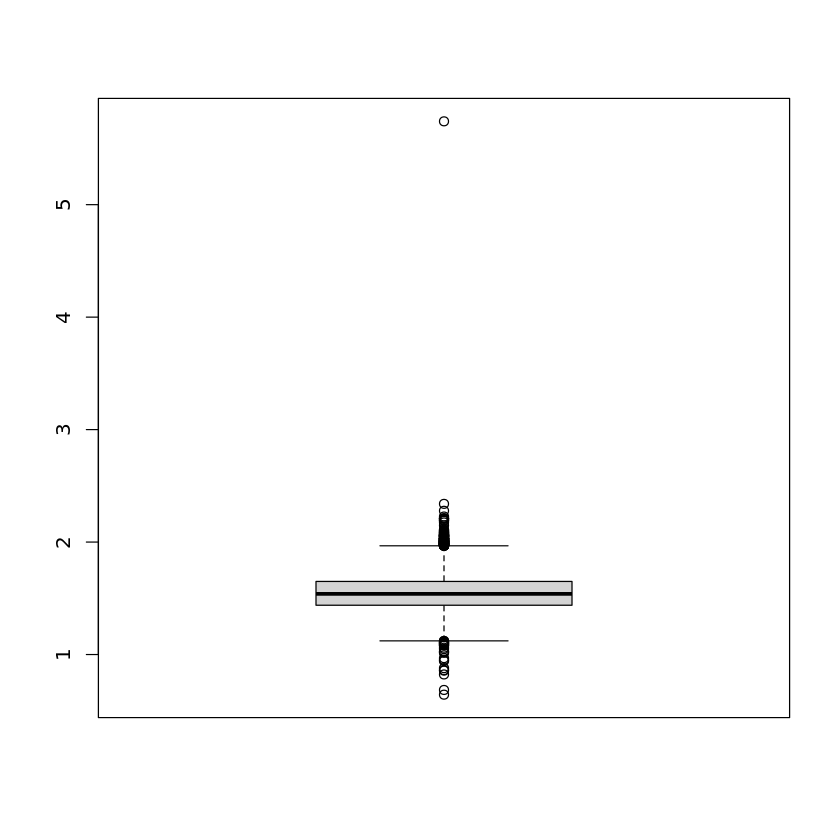

In [11]:
# Checking outlier
boxplot(CC_TIV_df$TIV) # one ppt has a biologically implausible TIV of ~6L

# Remove the row with the largest TIV
CC_TIV_df <- CC_TIV_df %>%
    filter(TIV != max(TIV))

In [12]:
# Creating quadratic model

# Adding TIV^2 column to df
CC_TIV_df <- CC_TIV_df %>%
    mutate(TIV_2 = TIV^2)

# Include TIV and TIV_2 in full model
CC2_lm <- lm(CC_prop ~ 
            TIV*sex + TIV_2*sex +
            TIV*age + TIV_2*age +
            TIV*hand + TIV_2*hand, data=CC_TIV_df)

# Generating model output
summary(CC2_lm)


Call:
lm(formula = CC_prop ~ TIV * sex + TIV_2 * sex + TIV * age + 
    TIV_2 * age + TIV * hand + TIV_2 * hand, data = CC_TIV_df)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.998e-03 -1.929e-04 -1.887e-05  1.723e-04  1.967e-03 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             6.012e-03  9.551e-04   6.294 3.13e-10 ***
TIV                    -3.354e-03  1.221e-03  -2.745  0.00605 ** 
sexMale                -2.683e-04  2.870e-04  -0.935  0.34987    
TIV_2                   8.874e-04  3.889e-04   2.282  0.02251 *  
age                    -2.683e-05  1.358e-05  -1.976  0.04813 *  
handRight-handed        3.308e-04  3.391e-04   0.975  0.32939    
TIV:sexMale             3.672e-04  3.697e-04   0.993  0.32053    
sexMale:TIV_2          -1.611e-04  1.194e-04  -1.349  0.17736    
TIV:age                 2.091e-05  1.733e-05   1.207  0.22758    
TIV_2:age              -6.160e-06  5.504e-06  -1.119  0.26308    
TIV


	Durbin-Watson test

data:  CC2_lm
DW = 2.0067, p-value = 0.7446
alternative hypothesis: true autocorrelation is greater than 0


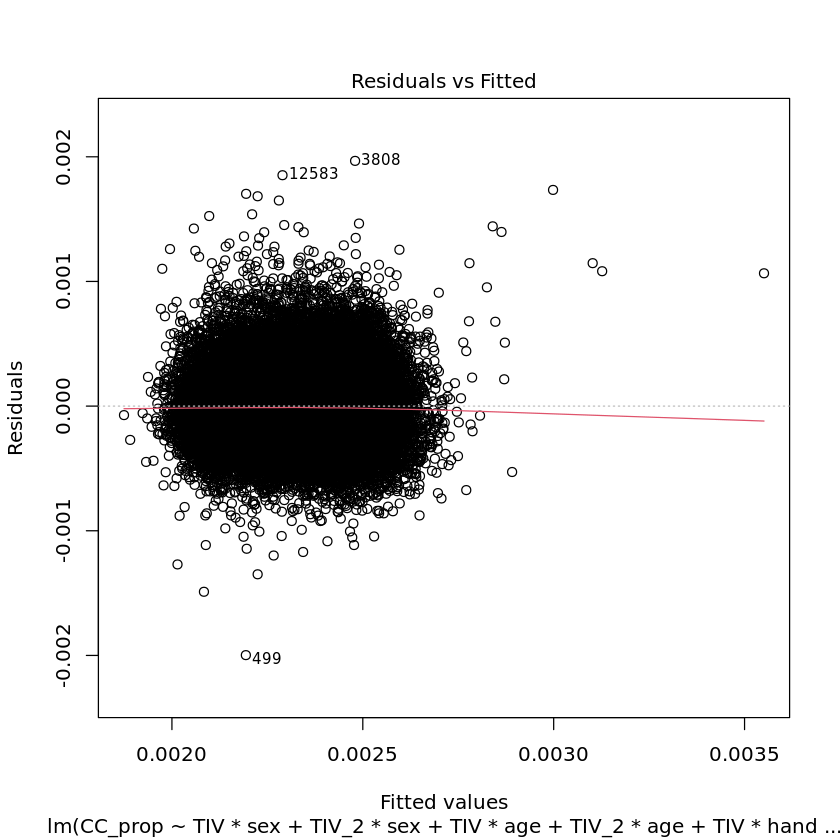

[1] 0.4822468

[1] 3.959384

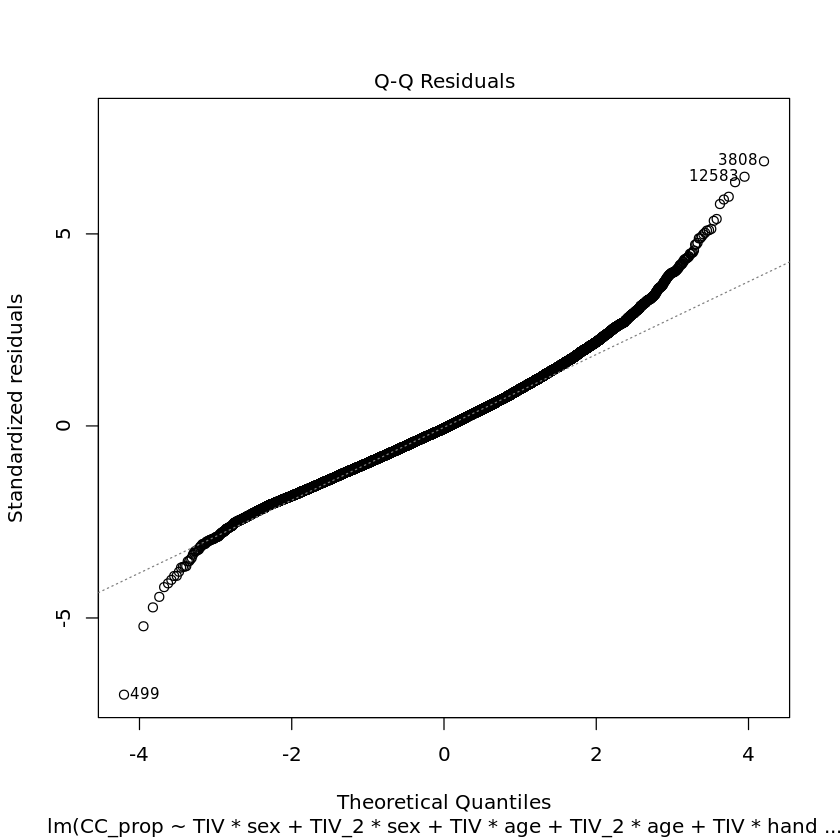

In [14]:
# Checking model assumptions

# Residuals vs. Fitted plot
plot(CC2_lm, which = 1) # satisfies linearity

# Durbin-Watson test for autocorrelation
dwtest(CC2_lm) # satisfies independence

# Q-Q plot of residuals
plot(CC2_lm, which = 2) # relative normality of residuals

# Skewnesss
skewness(CC_TIV_df$CC_total) # close to 0

# Kurtosis
kurtosis(CC_TIV_df$CC_total) # close to 3

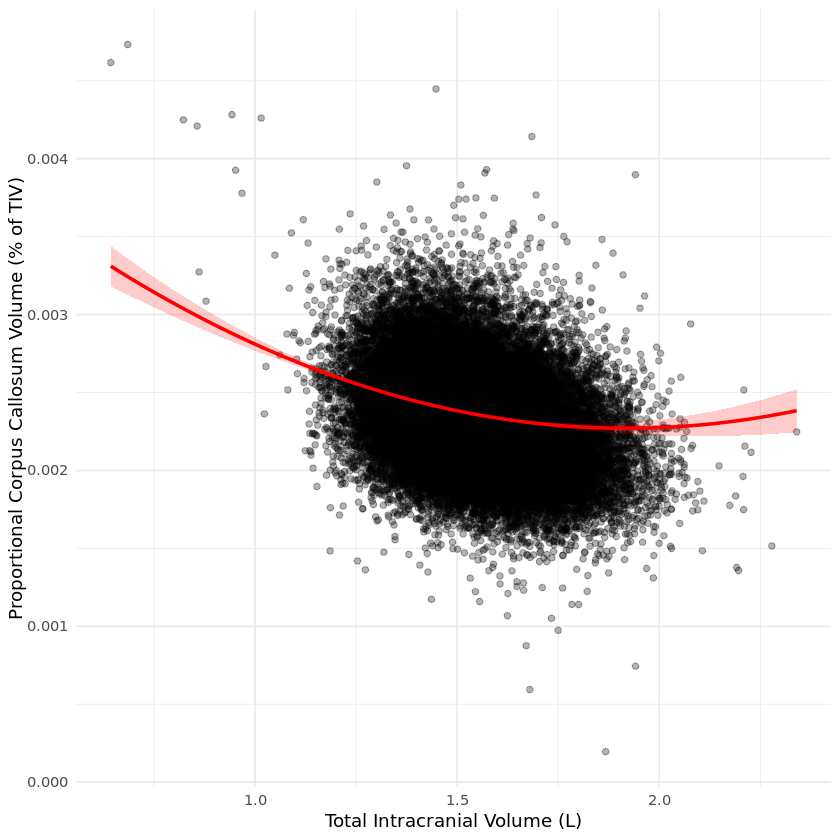

In [16]:
# Generating graph showing non-linear CC_prop x TIV relationship, holding sex, age and hand constant (i.e. at values of an 'average participant').

# Generate a sequence of TIV values across observed range
TIV_seq <- seq(min(CC_TIV_df$TIV), 
               max(CC_TIV_df$TIV), 
               length.out = 100)

# Create new data for prediction, holding covariates constant
newdata <- data.frame(
    TIV = TIV_seq,
    TIV_2 = TIV_seq^2,
    sex = "Female",  
    age = mean(CC_TIV_df$age),
    hand = "Right-handed"  
)

# Predict from full model
pred <- predict(CC2_lm, newdata = newdata, interval = "confidence")
newdata$fit <- pred[, "fit"]
newdata$lwr <- pred[, "lwr"]
newdata$upr <- pred[, "upr"]

# Plot
ggplot() +
    # Scatter points from original data
    geom_point(data = CC_TIV_df, aes(x = TIV, y = CC_prop), alpha = 0.3) +
  
    # Confidence ribbon from newdata
    geom_ribbon(data = newdata, aes(x = TIV, ymin = lwr, ymax = upr), 
              alpha = 0.2, fill = "red") +
  
    # Prediction line from newdata
    geom_line(data = newdata, aes(x = TIV, y = fit), 
            color = "red", linewidth = 1) +

    # Axis labels
    labs(
        x = "Total Intracranial Volume (L)",
        y = "Proportional Corpus Callosum Volume (% of TIV)"
    ) +

    # Set theme
    theme_minimal()

In [17]:
# Calculate effect sizes and CIs

# Effect sizes
eta_squared(CC2_lm, partial = TRUE)  # eta squared for effect size estimate

# Confidence intervals
confint(CC2_lm)

Parameter,Eta2_partial,CI,CI_low,CI_high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TIV,1.195285e-01,0.95,0.1145786542,1
sex,2.383960e-02,0.95,0.0213741444,1
TIV_2,8.727613e-04,0.95,0.0004457676,1
age,5.940834e-02,0.95,0.0556476835,1
hand,5.682992e-05,0.95,0.0000000000,1
TIV:sex,4.533408e-04,0.95,0.0001653536,1
sex:TIV_2,4.558260e-05,0.95,0.0000000000,1
TIV:age,4.214100e-05,0.95,0.0000000000,1
TIV_2:age,3.362027e-05,0.95,0.0000000000,1


,2.5 %,97.5 %
(Intercept),4.139547e-03,7.883770e-03
TIV,-5.747646e-03,-9.593752e-04
sexMale,-8.309489e-04,2.942646e-04
TIV_2,1.251342e-04,1.649593e-03
age,-5.344559e-05,-2.210801e-07
handRight-handed,-3.339411e-04,9.955030e-04
TIV:sexMale,-3.573420e-04,1.091786e-03
sexMale:TIV_2,-3.952290e-04,7.298824e-05
TIV:age,-1.305519e-05,5.487490e-05
TIV_2:age,-1.694873e-05,4.628419e-06
